In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [2]:
def get_mixture_coef(output,KMIX):
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_pi, out_sigma, out_mu = tf.split(output,3,1)
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.subtract(out_pi, max_pi)
    out_pi = tf.exp(out_pi)
    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)
    out_sigma = tf.exp(out_sigma)
    return out_pi, out_sigma, out_mu
def tf_normal(y, mu, sigma):
    oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
    result = tf.subtract(y, mu)
    result = tf.multiply(result,tf.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print 'error with sampling ensemble'
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
#         print(result[:3,:3])
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
#         print(rn[:3,:3])
    mu = 0
    std = 0
    idx = 0
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
#         print(result[:3,:3])
    return result


In [3]:
class MDN:
    def __init__(self):
        tf.reset_default_graph()
        NHIDDEN = 24
        STDEV = 0.5
        self.KMIX = 24
        NOUT = self.KMIX * 3 

        self.x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

        self.Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
        self.bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

        self.Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
        self.bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

        self.hidden_layer = tf.nn.tanh(tf.matmul(self.x, self.Wh) + self.bh)
        self.output = tf.matmul(self.hidden_layer,self.Wo) + self.bo
        self.out_pi, self.out_sigma, self.out_mu = get_mixture_coef(self.output,self.KMIX)
        
        self.lossfunc = get_lossfunc(self.out_pi, self.out_sigma, self.out_mu,self.y)
        self.train_op = tf.train.AdamOptimizer().minimize(self.lossfunc)
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.initialize_all_variables())
     
    def train(self, x_data,y_data,NEPOCH = 10000):
        
        self.loss = np.zeros(NEPOCH) # store the training progress here.
        for i in range(NEPOCH):
            self.sess.run(self.train_op,feed_dict={self.x: x_data, self.y: y_data})
            self.loss[i] = self.sess.run(self.lossfunc, feed_dict={self.x: x_data, self.y: y_data})
            print("Epoch: %d loss: %4.4f"%(i,self.loss[i]))
            
    def test(self,x_test):
        self.out_pi_test, self.out_sigma_test, self.out_mu_test = self.sess.run(get_mixture_coef(self.output,self.KMIX), feed_dict={self.x: x_test})
        self.y_test = generate_ensemble(self.out_pi_test, self.out_mu_test, self.out_sigma_test)
        return self.y_test


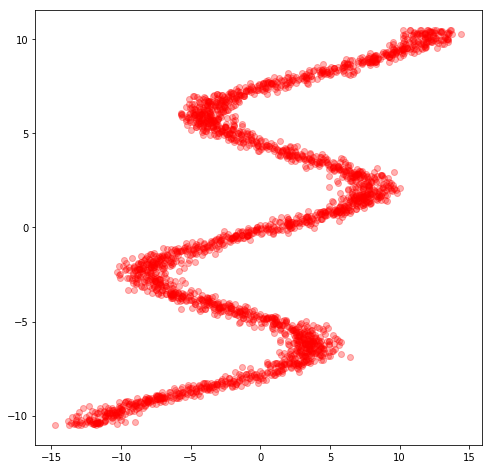

In [15]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+np.cos(0.75*y_data)+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [16]:
mdn = MDN()
mdn.train(x_data,y_data)
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1)
y_test = mdn.test(x_test)


/home/kiruthika/miniconda2/envs/magentatest/lib/python2.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0 loss: 4.8231
Epoch: 1 loss: 4.7737
Epoch: 2 loss: 4.7272
Epoch: 3 loss: 4.6817
Epoch: 4 loss: 4.6365
Epoch: 5 loss: 4.5917
Epoch: 6 loss: 4.5476
Epoch: 7 loss: 4.5044
Epoch: 8 loss: 4.4624
Epoch: 9 loss: 4.4216
Epoch: 10 loss: 4.3814
Epoch: 11 loss: 4.3418
Epoch: 12 loss: 4.3031
Epoch: 13 loss: 4.2653
Epoch: 14 loss: 4.2283
Epoch: 15 loss: 4.1919
Epoch: 16 loss: 4.1562
Epoch: 17 loss: 4.1212
Epoch: 18 loss: 4.0867
Epoch: 19 loss: 4.0529
Epoch: 20 loss: 4.0198
Epoch: 21 loss: 3.9875
Epoch: 22 loss: 3.9559
Epoch: 23 loss: 3.9251
Epoch: 24 loss: 3.8951
Epoch: 25 loss: 3.8660
Epoch: 26 loss: 3.8377
Epoch: 27 loss: 3.8104
Epoch: 28 loss: 3.7840
Epoch: 29 loss: 3.7584
Epoch: 30 loss: 3.7337
Epoch: 31 loss: 3.7099
Epoch: 32 loss: 3.6870
Epoch: 33 loss: 3.6648
Epoch: 34 loss: 3.6435
Epoch: 35 loss: 3.6229
Epoch: 36 loss: 3.6030
Epoch: 37 loss: 3.5838
Epoch: 38 loss: 3.5653
Epoch: 39 loss: 3.5474
Epoch: 40 loss: 3.5300
Epoch: 41 loss: 3.5131
Epoch: 42 loss: 3.4968
Epoch: 43 loss: 3.480

Epoch: 363 loss: 1.8795
Epoch: 364 loss: 1.8773
Epoch: 365 loss: 1.8751
Epoch: 366 loss: 1.8729
Epoch: 367 loss: 1.8706
Epoch: 368 loss: 1.8682
Epoch: 369 loss: 1.8664
Epoch: 370 loss: 1.8641
Epoch: 371 loss: 1.8625
Epoch: 372 loss: 1.8603
Epoch: 373 loss: 1.8588
Epoch: 374 loss: 1.8570
Epoch: 375 loss: 1.8552
Epoch: 376 loss: 1.8534
Epoch: 377 loss: 1.8513
Epoch: 378 loss: 1.8496
Epoch: 379 loss: 1.8480
Epoch: 380 loss: 1.8462
Epoch: 381 loss: 1.8444
Epoch: 382 loss: 1.8429
Epoch: 383 loss: 1.8412
Epoch: 384 loss: 1.8395
Epoch: 385 loss: 1.8381
Epoch: 386 loss: 1.8365
Epoch: 387 loss: 1.8351
Epoch: 388 loss: 1.8337
Epoch: 389 loss: 1.8323
Epoch: 390 loss: 1.8308
Epoch: 391 loss: 1.8296
Epoch: 392 loss: 1.8282
Epoch: 393 loss: 1.8269
Epoch: 394 loss: 1.8256
Epoch: 395 loss: 1.8244
Epoch: 396 loss: 1.8232
Epoch: 397 loss: 1.8219
Epoch: 398 loss: 1.8207
Epoch: 399 loss: 1.8196
Epoch: 400 loss: 1.8184
Epoch: 401 loss: 1.8173
Epoch: 402 loss: 1.8161
Epoch: 403 loss: 1.8150
Epoch: 404 loss:

Epoch: 728 loss: 1.6098
Epoch: 729 loss: 1.6090
Epoch: 730 loss: 1.6084
Epoch: 731 loss: 1.6078
Epoch: 732 loss: 1.6075
Epoch: 733 loss: 1.6073
Epoch: 734 loss: 1.6071
Epoch: 735 loss: 1.6065
Epoch: 736 loss: 1.6057
Epoch: 737 loss: 1.6050
Epoch: 738 loss: 1.6045
Epoch: 739 loss: 1.6040
Epoch: 740 loss: 1.6035
Epoch: 741 loss: 1.6031
Epoch: 742 loss: 1.6027
Epoch: 743 loss: 1.6028
Epoch: 744 loss: 1.6032
Epoch: 745 loss: 1.6012
Epoch: 746 loss: 1.6028
Epoch: 747 loss: 1.6025
Epoch: 748 loss: 1.6020
Epoch: 749 loss: 1.6015
Epoch: 750 loss: 1.6010
Epoch: 751 loss: 1.6006
Epoch: 752 loss: 1.6001
Epoch: 753 loss: 1.5997
Epoch: 754 loss: 1.5992
Epoch: 755 loss: 1.5988
Epoch: 756 loss: 1.5983
Epoch: 757 loss: 1.5978
Epoch: 758 loss: 1.5974
Epoch: 759 loss: 1.5969
Epoch: 760 loss: 1.5965
Epoch: 761 loss: 1.5960
Epoch: 762 loss: 1.5956
Epoch: 763 loss: 1.5951
Epoch: 764 loss: 1.5947
Epoch: 765 loss: 1.5942
Epoch: 766 loss: 1.5938
Epoch: 767 loss: 1.5933
Epoch: 768 loss: 1.5929
Epoch: 769 loss:

Epoch: 1093 loss: 1.4677
Epoch: 1094 loss: 1.4673
Epoch: 1095 loss: 1.4672
Epoch: 1096 loss: 1.4671
Epoch: 1097 loss: 1.4671
Epoch: 1098 loss: 1.4662
Epoch: 1099 loss: 1.4660
Epoch: 1100 loss: 1.4656
Epoch: 1101 loss: 1.4658
Epoch: 1102 loss: 1.4653
Epoch: 1103 loss: 1.4650
Epoch: 1104 loss: 1.4641
Epoch: 1105 loss: 1.4645
Epoch: 1106 loss: 1.4645
Epoch: 1107 loss: 1.4641
Epoch: 1108 loss: 1.4639
Epoch: 1109 loss: 1.4635
Epoch: 1110 loss: 1.4634
Epoch: 1111 loss: 1.4623
Epoch: 1112 loss: 1.4626
Epoch: 1113 loss: 1.4623
Epoch: 1114 loss: 1.4622
Epoch: 1115 loss: 1.4618
Epoch: 1116 loss: 1.4617
Epoch: 1117 loss: 1.4614
Epoch: 1118 loss: 1.4612
Epoch: 1119 loss: 1.4611
Epoch: 1120 loss: 1.4613
Epoch: 1121 loss: 1.4602
Epoch: 1122 loss: 1.4600
Epoch: 1123 loss: 1.4606
Epoch: 1124 loss: 1.4595
Epoch: 1125 loss: 1.4591
Epoch: 1126 loss: 1.4590
Epoch: 1127 loss: 1.4589
Epoch: 1128 loss: 1.4593
Epoch: 1129 loss: 1.4582
Epoch: 1130 loss: 1.4589
Epoch: 1131 loss: 1.4584
Epoch: 1132 loss: 1.4584


Epoch: 1454 loss: 1.3995
Epoch: 1455 loss: 1.3993
Epoch: 1456 loss: 1.3992
Epoch: 1457 loss: 1.3990
Epoch: 1458 loss: 1.3988
Epoch: 1459 loss: 1.3987
Epoch: 1460 loss: 1.3985
Epoch: 1461 loss: 1.3984
Epoch: 1462 loss: 1.3982
Epoch: 1463 loss: 1.3981
Epoch: 1464 loss: 1.3979
Epoch: 1465 loss: 1.3977
Epoch: 1466 loss: 1.3976
Epoch: 1467 loss: 1.3974
Epoch: 1468 loss: 1.3972
Epoch: 1469 loss: 1.3971
Epoch: 1470 loss: 1.3969
Epoch: 1471 loss: 1.3967
Epoch: 1472 loss: 1.3966
Epoch: 1473 loss: 1.3964
Epoch: 1474 loss: 1.3963
Epoch: 1475 loss: 1.3961
Epoch: 1476 loss: 1.3959
Epoch: 1477 loss: 1.3957
Epoch: 1478 loss: 1.3956
Epoch: 1479 loss: 1.3954
Epoch: 1480 loss: 1.3952
Epoch: 1481 loss: 1.3951
Epoch: 1482 loss: 1.3949
Epoch: 1483 loss: 1.3947
Epoch: 1484 loss: 1.3946
Epoch: 1485 loss: 1.3944
Epoch: 1486 loss: 1.3942
Epoch: 1487 loss: 1.3940
Epoch: 1488 loss: 1.3939
Epoch: 1489 loss: 1.3937
Epoch: 1490 loss: 1.3935
Epoch: 1491 loss: 1.3933
Epoch: 1492 loss: 1.3932
Epoch: 1493 loss: 1.3930


Epoch: 1814 loss: 1.3584
Epoch: 1815 loss: 1.3584
Epoch: 1816 loss: 1.3583
Epoch: 1817 loss: 1.3583
Epoch: 1818 loss: 1.3583
Epoch: 1819 loss: 1.3582
Epoch: 1820 loss: 1.3580
Epoch: 1821 loss: 1.3579
Epoch: 1822 loss: 1.3577
Epoch: 1823 loss: 1.3575
Epoch: 1824 loss: 1.3576
Epoch: 1825 loss: 1.3575
Epoch: 1826 loss: 1.3573
Epoch: 1827 loss: 1.3574
Epoch: 1828 loss: 1.3573
Epoch: 1829 loss: 1.3573
Epoch: 1830 loss: 1.3573
Epoch: 1831 loss: 1.3574
Epoch: 1832 loss: 1.3573
Epoch: 1833 loss: 1.3570
Epoch: 1834 loss: 1.3568
Epoch: 1835 loss: 1.3568
Epoch: 1836 loss: 1.3568
Epoch: 1837 loss: 1.3569
Epoch: 1838 loss: 1.3569
Epoch: 1839 loss: 1.3568
Epoch: 1840 loss: 1.3566
Epoch: 1841 loss: 1.3563
Epoch: 1842 loss: 1.3564
Epoch: 1843 loss: 1.3564
Epoch: 1844 loss: 1.3563
Epoch: 1845 loss: 1.3563
Epoch: 1846 loss: 1.3562
Epoch: 1847 loss: 1.3562
Epoch: 1848 loss: 1.3560
Epoch: 1849 loss: 1.3560
Epoch: 1850 loss: 1.3559
Epoch: 1851 loss: 1.3558
Epoch: 1852 loss: 1.3558
Epoch: 1853 loss: 1.3558


Epoch: 2178 loss: 1.3369
Epoch: 2179 loss: 1.3369
Epoch: 2180 loss: 1.3368
Epoch: 2181 loss: 1.3367
Epoch: 2182 loss: 1.3366
Epoch: 2183 loss: 1.3366
Epoch: 2184 loss: 1.3366
Epoch: 2185 loss: 1.3365
Epoch: 2186 loss: 1.3365
Epoch: 2187 loss: 1.3364
Epoch: 2188 loss: 1.3364
Epoch: 2189 loss: 1.3363
Epoch: 2190 loss: 1.3362
Epoch: 2191 loss: 1.3362
Epoch: 2192 loss: 1.3362
Epoch: 2193 loss: 1.3361
Epoch: 2194 loss: 1.3361
Epoch: 2195 loss: 1.3360
Epoch: 2196 loss: 1.3359
Epoch: 2197 loss: 1.3358
Epoch: 2198 loss: 1.3358
Epoch: 2199 loss: 1.3358
Epoch: 2200 loss: 1.3357
Epoch: 2201 loss: 1.3357
Epoch: 2202 loss: 1.3356
Epoch: 2203 loss: 1.3356
Epoch: 2204 loss: 1.3355
Epoch: 2205 loss: 1.3354
Epoch: 2206 loss: 1.3354
Epoch: 2207 loss: 1.3354
Epoch: 2208 loss: 1.3353
Epoch: 2209 loss: 1.3352
Epoch: 2210 loss: 1.3352
Epoch: 2211 loss: 1.3351
Epoch: 2212 loss: 1.3351
Epoch: 2213 loss: 1.3350
Epoch: 2214 loss: 1.3350
Epoch: 2215 loss: 1.3350
Epoch: 2216 loss: 1.3349
Epoch: 2217 loss: 1.3349


Epoch: 2542 loss: 1.3173
Epoch: 2543 loss: 1.3173
Epoch: 2544 loss: 1.3171
Epoch: 2545 loss: 1.3171
Epoch: 2546 loss: 1.3169
Epoch: 2547 loss: 1.3169
Epoch: 2548 loss: 1.3168
Epoch: 2549 loss: 1.3167
Epoch: 2550 loss: 1.3166
Epoch: 2551 loss: 1.3167
Epoch: 2552 loss: 1.3165
Epoch: 2553 loss: 1.3165
Epoch: 2554 loss: 1.3164
Epoch: 2555 loss: 1.3164
Epoch: 2556 loss: 1.3164
Epoch: 2557 loss: 1.3165
Epoch: 2558 loss: 1.3165
Epoch: 2559 loss: 1.3165
Epoch: 2560 loss: 1.3163
Epoch: 2561 loss: 1.3161
Epoch: 2562 loss: 1.3160
Epoch: 2563 loss: 1.3159
Epoch: 2564 loss: 1.3158
Epoch: 2565 loss: 1.3158
Epoch: 2566 loss: 1.3157
Epoch: 2567 loss: 1.3157
Epoch: 2568 loss: 1.3157
Epoch: 2569 loss: 1.3156
Epoch: 2570 loss: 1.3156
Epoch: 2571 loss: 1.3156
Epoch: 2572 loss: 1.3155
Epoch: 2573 loss: 1.3154
Epoch: 2574 loss: 1.3154
Epoch: 2575 loss: 1.3153
Epoch: 2576 loss: 1.3152
Epoch: 2577 loss: 1.3152
Epoch: 2578 loss: 1.3151
Epoch: 2579 loss: 1.3151
Epoch: 2580 loss: 1.3150
Epoch: 2581 loss: 1.3150


Epoch: 2874 loss: 1.3000
Epoch: 2875 loss: 1.3001
Epoch: 2876 loss: 1.3007
Epoch: 2877 loss: 1.3024
Epoch: 2878 loss: 1.3005
Epoch: 2879 loss: 1.2999
Epoch: 2880 loss: 1.2996
Epoch: 2881 loss: 1.2993
Epoch: 2882 loss: 1.2995
Epoch: 2883 loss: 1.2996
Epoch: 2884 loss: 1.2994
Epoch: 2885 loss: 1.2993
Epoch: 2886 loss: 1.2997
Epoch: 2887 loss: 1.3002
Epoch: 2888 loss: 1.3001
Epoch: 2889 loss: 1.2998
Epoch: 2890 loss: 1.2991
Epoch: 2891 loss: 1.2985
Epoch: 2892 loss: 1.2986
Epoch: 2893 loss: 1.2987
Epoch: 2894 loss: 1.2989
Epoch: 2895 loss: 1.2987
Epoch: 2896 loss: 1.2982
Epoch: 2897 loss: 1.2982
Epoch: 2898 loss: 1.2982
Epoch: 2899 loss: 1.2984
Epoch: 2900 loss: 1.2983
Epoch: 2901 loss: 1.2981
Epoch: 2902 loss: 1.2979
Epoch: 2903 loss: 1.2977
Epoch: 2904 loss: 1.2976
Epoch: 2905 loss: 1.2975
Epoch: 2906 loss: 1.2975
Epoch: 2907 loss: 1.2977
Epoch: 2908 loss: 1.2982
Epoch: 2909 loss: 1.2991
Epoch: 2910 loss: 1.2992
Epoch: 2911 loss: 1.2981
Epoch: 2912 loss: 1.2973
Epoch: 2913 loss: 1.2970


Epoch: 3206 loss: 1.2739
Epoch: 3207 loss: 1.2735
Epoch: 3208 loss: 1.2731
Epoch: 3209 loss: 1.2725
Epoch: 3210 loss: 1.2729
Epoch: 3211 loss: 1.2724
Epoch: 3212 loss: 1.2728
Epoch: 3213 loss: 1.2727
Epoch: 3214 loss: 1.2725
Epoch: 3215 loss: 1.2726
Epoch: 3216 loss: 1.2726
Epoch: 3217 loss: 1.2728
Epoch: 3218 loss: 1.2733
Epoch: 3219 loss: 1.2743
Epoch: 3220 loss: 1.2748
Epoch: 3221 loss: 1.2743
Epoch: 3222 loss: 1.2730
Epoch: 3223 loss: 1.2726
Epoch: 3224 loss: 1.2725
Epoch: 3225 loss: 1.2725
Epoch: 3226 loss: 1.2726
Epoch: 3227 loss: 1.2728
Epoch: 3228 loss: 1.2731
Epoch: 3229 loss: 1.2727
Epoch: 3230 loss: 1.2724
Epoch: 3231 loss: 1.2722
Epoch: 3232 loss: 1.2721
Epoch: 3233 loss: 1.2721
Epoch: 3234 loss: 1.2721
Epoch: 3235 loss: 1.2722
Epoch: 3236 loss: 1.2722
Epoch: 3237 loss: 1.2722
Epoch: 3238 loss: 1.2722
Epoch: 3239 loss: 1.2723
Epoch: 3240 loss: 1.2724
Epoch: 3241 loss: 1.2725
Epoch: 3242 loss: 1.2726
Epoch: 3243 loss: 1.2723
Epoch: 3244 loss: 1.2720
Epoch: 3245 loss: 1.2717


Epoch: 3537 loss: 1.2621
Epoch: 3538 loss: 1.2622
Epoch: 3539 loss: 1.2622
Epoch: 3540 loss: 1.2624
Epoch: 3541 loss: 1.2626
Epoch: 3542 loss: 1.2628
Epoch: 3543 loss: 1.2630
Epoch: 3544 loss: 1.2628
Epoch: 3545 loss: 1.2626
Epoch: 3546 loss: 1.2623
Epoch: 3547 loss: 1.2622
Epoch: 3548 loss: 1.2620
Epoch: 3549 loss: 1.2619
Epoch: 3550 loss: 1.2619
Epoch: 3551 loss: 1.2618
Epoch: 3552 loss: 1.2618
Epoch: 3553 loss: 1.2618
Epoch: 3554 loss: 1.2619
Epoch: 3555 loss: 1.2620
Epoch: 3556 loss: 1.2620
Epoch: 3557 loss: 1.2621
Epoch: 3558 loss: 1.2622
Epoch: 3559 loss: 1.2624
Epoch: 3560 loss: 1.2622
Epoch: 3561 loss: 1.2620
Epoch: 3562 loss: 1.2618
Epoch: 3563 loss: 1.2617
Epoch: 3564 loss: 1.2616
Epoch: 3565 loss: 1.2616
Epoch: 3566 loss: 1.2616
Epoch: 3567 loss: 1.2616
Epoch: 3568 loss: 1.2615
Epoch: 3569 loss: 1.2615
Epoch: 3570 loss: 1.2615
Epoch: 3571 loss: 1.2615
Epoch: 3572 loss: 1.2615
Epoch: 3573 loss: 1.2614
Epoch: 3574 loss: 1.2614
Epoch: 3575 loss: 1.2615
Epoch: 3576 loss: 1.2617


Epoch: 3871 loss: 1.2543
Epoch: 3872 loss: 1.2544
Epoch: 3873 loss: 1.2544
Epoch: 3874 loss: 1.2545
Epoch: 3875 loss: 1.2546
Epoch: 3876 loss: 1.2547
Epoch: 3877 loss: 1.2548
Epoch: 3878 loss: 1.2549
Epoch: 3879 loss: 1.2548
Epoch: 3880 loss: 1.2549
Epoch: 3881 loss: 1.2549
Epoch: 3882 loss: 1.2550
Epoch: 3883 loss: 1.2547
Epoch: 3884 loss: 1.2543
Epoch: 3885 loss: 1.2540
Epoch: 3886 loss: 1.2539
Epoch: 3887 loss: 1.2540
Epoch: 3888 loss: 1.2542
Epoch: 3889 loss: 1.2544
Epoch: 3890 loss: 1.2544
Epoch: 3891 loss: 1.2543
Epoch: 3892 loss: 1.2543
Epoch: 3893 loss: 1.2544
Epoch: 3894 loss: 1.2544
Epoch: 3895 loss: 1.2543
Epoch: 3896 loss: 1.2541
Epoch: 3897 loss: 1.2539
Epoch: 3898 loss: 1.2538
Epoch: 3899 loss: 1.2536
Epoch: 3900 loss: 1.2535
Epoch: 3901 loss: 1.2535
Epoch: 3902 loss: 1.2534
Epoch: 3903 loss: 1.2534
Epoch: 3904 loss: 1.2534
Epoch: 3905 loss: 1.2534
Epoch: 3906 loss: 1.2534
Epoch: 3907 loss: 1.2536
Epoch: 3908 loss: 1.2540
Epoch: 3909 loss: 1.2543
Epoch: 3910 loss: 1.2548


Epoch: 4205 loss: 1.2447
Epoch: 4206 loss: 1.2445
Epoch: 4207 loss: 1.2443
Epoch: 4208 loss: 1.2442
Epoch: 4209 loss: 1.2443
Epoch: 4210 loss: 1.2444
Epoch: 4211 loss: 1.2443
Epoch: 4212 loss: 1.2442
Epoch: 4213 loss: 1.2441
Epoch: 4214 loss: 1.2440
Epoch: 4215 loss: 1.2439
Epoch: 4216 loss: 1.2438
Epoch: 4217 loss: 1.2440
Epoch: 4218 loss: 1.2446
Epoch: 4219 loss: 1.2456
Epoch: 4220 loss: 1.2458
Epoch: 4221 loss: 1.2449
Epoch: 4222 loss: 1.2447
Epoch: 4223 loss: 1.2447
Epoch: 4224 loss: 1.2449
Epoch: 4225 loss: 1.2448
Epoch: 4226 loss: 1.2449
Epoch: 4227 loss: 1.2447
Epoch: 4228 loss: 1.2443
Epoch: 4229 loss: 1.2441
Epoch: 4230 loss: 1.2440
Epoch: 4231 loss: 1.2439
Epoch: 4232 loss: 1.2433
Epoch: 4233 loss: 1.2431
Epoch: 4234 loss: 1.2434
Epoch: 4235 loss: 1.2437
Epoch: 4236 loss: 1.2438
Epoch: 4237 loss: 1.2438
Epoch: 4238 loss: 1.2443
Epoch: 4239 loss: 1.2449
Epoch: 4240 loss: 1.2449
Epoch: 4241 loss: 1.2443
Epoch: 4242 loss: 1.2436
Epoch: 4243 loss: 1.2432
Epoch: 4244 loss: 1.2433


Epoch: 4537 loss: 1.2372
Epoch: 4538 loss: 1.2375
Epoch: 4539 loss: 1.2376
Epoch: 4540 loss: 1.2377
Epoch: 4541 loss: 1.2377
Epoch: 4542 loss: 1.2375
Epoch: 4543 loss: 1.2371
Epoch: 4544 loss: 1.2369
Epoch: 4545 loss: 1.2368
Epoch: 4546 loss: 1.2368
Epoch: 4547 loss: 1.2370
Epoch: 4548 loss: 1.2371
Epoch: 4549 loss: 1.2375
Epoch: 4550 loss: 1.2377
Epoch: 4551 loss: 1.2384
Epoch: 4552 loss: 1.2382
Epoch: 4553 loss: 1.2384
Epoch: 4554 loss: 1.2384
Epoch: 4555 loss: 1.2374
Epoch: 4556 loss: 1.2369
Epoch: 4557 loss: 1.2366
Epoch: 4558 loss: 1.2364
Epoch: 4559 loss: 1.2366
Epoch: 4560 loss: 1.2367
Epoch: 4561 loss: 1.2367
Epoch: 4562 loss: 1.2366
Epoch: 4563 loss: 1.2365
Epoch: 4564 loss: 1.2363
Epoch: 4565 loss: 1.2363
Epoch: 4566 loss: 1.2364
Epoch: 4567 loss: 1.2370
Epoch: 4568 loss: 1.2388
Epoch: 4569 loss: 1.2400
Epoch: 4570 loss: 1.2420
Epoch: 4571 loss: 1.2376
Epoch: 4572 loss: 1.2373
Epoch: 4573 loss: 1.2394
Epoch: 4574 loss: 1.2396
Epoch: 4575 loss: 1.2386
Epoch: 4576 loss: 1.2374


Epoch: 4870 loss: 1.2426
Epoch: 4871 loss: 1.2437
Epoch: 4872 loss: 1.2426
Epoch: 4873 loss: 1.2420
Epoch: 4874 loss: 1.2416
Epoch: 4875 loss: 1.2421
Epoch: 4876 loss: 1.2425
Epoch: 4877 loss: 1.2428
Epoch: 4878 loss: 1.2421
Epoch: 4879 loss: 1.2424
Epoch: 4880 loss: 1.2427
Epoch: 4881 loss: 1.2423
Epoch: 4882 loss: 1.2417
Epoch: 4883 loss: 1.2420
Epoch: 4884 loss: 1.2421
Epoch: 4885 loss: 1.2421
Epoch: 4886 loss: 1.2418
Epoch: 4887 loss: 1.2417
Epoch: 4888 loss: 1.2416
Epoch: 4889 loss: 1.2416
Epoch: 4890 loss: 1.2414
Epoch: 4891 loss: 1.2412
Epoch: 4892 loss: 1.2413
Epoch: 4893 loss: 1.2414
Epoch: 4894 loss: 1.2409
Epoch: 4895 loss: 1.2405
Epoch: 4896 loss: 1.2404
Epoch: 4897 loss: 1.2407
Epoch: 4898 loss: 1.2408
Epoch: 4899 loss: 1.2407
Epoch: 4900 loss: 1.2410
Epoch: 4901 loss: 1.2414
Epoch: 4902 loss: 1.2412
Epoch: 4903 loss: 1.2408
Epoch: 4904 loss: 1.2405
Epoch: 4905 loss: 1.2400
Epoch: 4906 loss: 1.2396
Epoch: 4907 loss: 1.2397
Epoch: 4908 loss: 1.2396
Epoch: 4909 loss: 1.2396


Epoch: 5203 loss: 1.2369
Epoch: 5204 loss: 1.2373
Epoch: 5205 loss: 1.2368
Epoch: 5206 loss: 1.2367
Epoch: 5207 loss: 1.2368
Epoch: 5208 loss: 1.2370
Epoch: 5209 loss: 1.2374
Epoch: 5210 loss: 1.2376
Epoch: 5211 loss: 1.2370
Epoch: 5212 loss: 1.2368
Epoch: 5213 loss: 1.2368
Epoch: 5214 loss: 1.2369
Epoch: 5215 loss: 1.2375
Epoch: 5216 loss: 1.2381
Epoch: 5217 loss: 1.2368
Epoch: 5218 loss: 1.2369
Epoch: 5219 loss: 1.2373
Epoch: 5220 loss: 1.2374
Epoch: 5221 loss: 1.2366
Epoch: 5222 loss: 1.2378
Epoch: 5223 loss: 1.2380
Epoch: 5224 loss: 1.2380
Epoch: 5225 loss: 1.2380
Epoch: 5226 loss: 1.2380
Epoch: 5227 loss: 1.2381
Epoch: 5228 loss: 1.2374
Epoch: 5229 loss: 1.2381
Epoch: 5230 loss: 1.2379
Epoch: 5231 loss: 1.2378
Epoch: 5232 loss: 1.2377
Epoch: 5233 loss: 1.2376
Epoch: 5234 loss: 1.2374
Epoch: 5235 loss: 1.2371
Epoch: 5236 loss: 1.2369
Epoch: 5237 loss: 1.2366
Epoch: 5238 loss: 1.2371
Epoch: 5239 loss: 1.2373
Epoch: 5240 loss: 1.2375
Epoch: 5241 loss: 1.2375
Epoch: 5242 loss: 1.2375


Epoch: 5535 loss: 1.2333
Epoch: 5536 loss: 1.2335
Epoch: 5537 loss: 1.2335
Epoch: 5538 loss: 1.2334
Epoch: 5539 loss: 1.2335
Epoch: 5540 loss: 1.2335
Epoch: 5541 loss: 1.2336
Epoch: 5542 loss: 1.2333
Epoch: 5543 loss: 1.2335
Epoch: 5544 loss: 1.2336
Epoch: 5545 loss: 1.2340
Epoch: 5546 loss: 1.2337
Epoch: 5547 loss: 1.2335
Epoch: 5548 loss: 1.2331
Epoch: 5549 loss: 1.2330
Epoch: 5550 loss: 1.2332
Epoch: 5551 loss: 1.2333
Epoch: 5552 loss: 1.2330
Epoch: 5553 loss: 1.2325
Epoch: 5554 loss: 1.2322
Epoch: 5555 loss: 1.2322
Epoch: 5556 loss: 1.2326
Epoch: 5557 loss: 1.2327
Epoch: 5558 loss: 1.2325
Epoch: 5559 loss: 1.2326
Epoch: 5560 loss: 1.2333
Epoch: 5561 loss: 1.2331
Epoch: 5562 loss: 1.2330
Epoch: 5563 loss: 1.2330
Epoch: 5564 loss: 1.2330
Epoch: 5565 loss: 1.2327
Epoch: 5566 loss: 1.2334
Epoch: 5567 loss: 1.2329
Epoch: 5568 loss: 1.2339
Epoch: 5569 loss: 1.2339
Epoch: 5570 loss: 1.2341
Epoch: 5571 loss: 1.2345
Epoch: 5572 loss: 1.2349
Epoch: 5573 loss: 1.2349
Epoch: 5574 loss: 1.2346


Epoch: 5868 loss: 1.2290
Epoch: 5869 loss: 1.2292
Epoch: 5870 loss: 1.2296
Epoch: 5871 loss: 1.2297
Epoch: 5872 loss: 1.2289
Epoch: 5873 loss: 1.2287
Epoch: 5874 loss: 1.2287
Epoch: 5875 loss: 1.2289
Epoch: 5876 loss: 1.2293
Epoch: 5877 loss: 1.2292
Epoch: 5878 loss: 1.2291
Epoch: 5879 loss: 1.2287
Epoch: 5880 loss: 1.2285
Epoch: 5881 loss: 1.2285
Epoch: 5882 loss: 1.2284
Epoch: 5883 loss: 1.2282
Epoch: 5884 loss: 1.2281
Epoch: 5885 loss: 1.2281
Epoch: 5886 loss: 1.2282
Epoch: 5887 loss: 1.2282
Epoch: 5888 loss: 1.2282
Epoch: 5889 loss: 1.2281
Epoch: 5890 loss: 1.2282
Epoch: 5891 loss: 1.2282
Epoch: 5892 loss: 1.2283
Epoch: 5893 loss: 1.2283
Epoch: 5894 loss: 1.2286
Epoch: 5895 loss: 1.2288
Epoch: 5896 loss: 1.2289
Epoch: 5897 loss: 1.2288
Epoch: 5898 loss: 1.2290
Epoch: 5899 loss: 1.2294
Epoch: 5900 loss: 1.2294
Epoch: 5901 loss: 1.2294
Epoch: 5902 loss: 1.2294
Epoch: 5903 loss: 1.2295
Epoch: 5904 loss: 1.2295
Epoch: 5905 loss: 1.2289
Epoch: 5906 loss: 1.2303
Epoch: 5907 loss: 1.2312


Epoch: 6201 loss: 1.2225
Epoch: 6202 loss: 1.2227
Epoch: 6203 loss: 1.2230
Epoch: 6204 loss: 1.2229
Epoch: 6205 loss: 1.2223
Epoch: 6206 loss: 1.2223
Epoch: 6207 loss: 1.2226
Epoch: 6208 loss: 1.2226
Epoch: 6209 loss: 1.2226
Epoch: 6210 loss: 1.2222
Epoch: 6211 loss: 1.2221
Epoch: 6212 loss: 1.2222
Epoch: 6213 loss: 1.2227
Epoch: 6214 loss: 1.2230
Epoch: 6215 loss: 1.2224
Epoch: 6216 loss: 1.2218
Epoch: 6217 loss: 1.2217
Epoch: 6218 loss: 1.2219
Epoch: 6219 loss: 1.2222
Epoch: 6220 loss: 1.2222
Epoch: 6221 loss: 1.2221
Epoch: 6222 loss: 1.2220
Epoch: 6223 loss: 1.2222
Epoch: 6224 loss: 1.2224
Epoch: 6225 loss: 1.2223
Epoch: 6226 loss: 1.2219
Epoch: 6227 loss: 1.2217
Epoch: 6228 loss: 1.2218
Epoch: 6229 loss: 1.2220
Epoch: 6230 loss: 1.2220
Epoch: 6231 loss: 1.2221
Epoch: 6232 loss: 1.2223
Epoch: 6233 loss: 1.2231
Epoch: 6234 loss: 1.2228
Epoch: 6235 loss: 1.2223
Epoch: 6236 loss: 1.2217
Epoch: 6237 loss: 1.2214
Epoch: 6238 loss: 1.2215
Epoch: 6239 loss: 1.2217
Epoch: 6240 loss: 1.2219


Epoch: 6533 loss: 1.2179
Epoch: 6534 loss: 1.2177
Epoch: 6535 loss: 1.2176
Epoch: 6536 loss: 1.2175
Epoch: 6537 loss: 1.2174
Epoch: 6538 loss: 1.2175
Epoch: 6539 loss: 1.2176
Epoch: 6540 loss: 1.2179
Epoch: 6541 loss: 1.2181
Epoch: 6542 loss: 1.2182
Epoch: 6543 loss: 1.2182
Epoch: 6544 loss: 1.2181
Epoch: 6545 loss: 1.2182
Epoch: 6546 loss: 1.2181
Epoch: 6547 loss: 1.2179
Epoch: 6548 loss: 1.2177
Epoch: 6549 loss: 1.2175
Epoch: 6550 loss: 1.2173
Epoch: 6551 loss: 1.2172
Epoch: 6552 loss: 1.2172
Epoch: 6553 loss: 1.2172
Epoch: 6554 loss: 1.2173
Epoch: 6555 loss: 1.2174
Epoch: 6556 loss: 1.2177
Epoch: 6557 loss: 1.2181
Epoch: 6558 loss: 1.2184
Epoch: 6559 loss: 1.2183
Epoch: 6560 loss: 1.2181
Epoch: 6561 loss: 1.2179
Epoch: 6562 loss: 1.2176
Epoch: 6563 loss: 1.2174
Epoch: 6564 loss: 1.2172
Epoch: 6565 loss: 1.2171
Epoch: 6566 loss: 1.2171
Epoch: 6567 loss: 1.2171
Epoch: 6568 loss: 1.2172
Epoch: 6569 loss: 1.2172
Epoch: 6570 loss: 1.2172
Epoch: 6571 loss: 1.2172
Epoch: 6572 loss: 1.2173


Epoch: 6866 loss: 1.2152
Epoch: 6867 loss: 1.2151
Epoch: 6868 loss: 1.2143
Epoch: 6869 loss: 1.2144
Epoch: 6870 loss: 1.2149
Epoch: 6871 loss: 1.2155
Epoch: 6872 loss: 1.2154
Epoch: 6873 loss: 1.2142
Epoch: 6874 loss: 1.2140
Epoch: 6875 loss: 1.2144
Epoch: 6876 loss: 1.2143
Epoch: 6877 loss: 1.2143
Epoch: 6878 loss: 1.2143
Epoch: 6879 loss: 1.2146
Epoch: 6880 loss: 1.2148
Epoch: 6881 loss: 1.2141
Epoch: 6882 loss: 1.2142
Epoch: 6883 loss: 1.2149
Epoch: 6884 loss: 1.2150
Epoch: 6885 loss: 1.2144
Epoch: 6886 loss: 1.2142
Epoch: 6887 loss: 1.2141
Epoch: 6888 loss: 1.2140
Epoch: 6889 loss: 1.2141
Epoch: 6890 loss: 1.2141
Epoch: 6891 loss: 1.2139
Epoch: 6892 loss: 1.2139
Epoch: 6893 loss: 1.2140
Epoch: 6894 loss: 1.2138
Epoch: 6895 loss: 1.2138
Epoch: 6896 loss: 1.2141
Epoch: 6897 loss: 1.2144
Epoch: 6898 loss: 1.2146
Epoch: 6899 loss: 1.2142
Epoch: 6900 loss: 1.2142
Epoch: 6901 loss: 1.2139
Epoch: 6902 loss: 1.2135
Epoch: 6903 loss: 1.2132
Epoch: 6904 loss: 1.2132
Epoch: 6905 loss: 1.2134


Epoch: 7201 loss: 1.2123
Epoch: 7202 loss: 1.2126
Epoch: 7203 loss: 1.2122
Epoch: 7204 loss: 1.2117
Epoch: 7205 loss: 1.2117
Epoch: 7206 loss: 1.2116
Epoch: 7207 loss: 1.2114
Epoch: 7208 loss: 1.2120
Epoch: 7209 loss: 1.2124
Epoch: 7210 loss: 1.2128
Epoch: 7211 loss: 1.2121
Epoch: 7212 loss: 1.2123
Epoch: 7213 loss: 1.2115
Epoch: 7214 loss: 1.2116
Epoch: 7215 loss: 1.2122
Epoch: 7216 loss: 1.2120
Epoch: 7217 loss: 1.2123
Epoch: 7218 loss: 1.2120
Epoch: 7219 loss: 1.2121
Epoch: 7220 loss: 1.2115
Epoch: 7221 loss: 1.2112
Epoch: 7222 loss: 1.2113
Epoch: 7223 loss: 1.2118
Epoch: 7224 loss: 1.2120
Epoch: 7225 loss: 1.2121
Epoch: 7226 loss: 1.2120
Epoch: 7227 loss: 1.2125
Epoch: 7228 loss: 1.2131
Epoch: 7229 loss: 1.2136
Epoch: 7230 loss: 1.2134
Epoch: 7231 loss: 1.2131
Epoch: 7232 loss: 1.2120
Epoch: 7233 loss: 1.2116
Epoch: 7234 loss: 1.2112
Epoch: 7235 loss: 1.2113
Epoch: 7236 loss: 1.2113
Epoch: 7237 loss: 1.2111
Epoch: 7238 loss: 1.2114
Epoch: 7239 loss: 1.2112
Epoch: 7240 loss: 1.2113


Epoch: 7534 loss: 1.2173
Epoch: 7535 loss: 1.2184
Epoch: 7536 loss: 1.2174
Epoch: 7537 loss: 1.2176
Epoch: 7538 loss: 1.2171
Epoch: 7539 loss: 1.2179
Epoch: 7540 loss: 1.2180
Epoch: 7541 loss: 1.2171
Epoch: 7542 loss: 1.2168
Epoch: 7543 loss: 1.2172
Epoch: 7544 loss: 1.2173
Epoch: 7545 loss: 1.2170
Epoch: 7546 loss: 1.2165
Epoch: 7547 loss: 1.2164
Epoch: 7548 loss: 1.2164
Epoch: 7549 loss: 1.2161
Epoch: 7550 loss: 1.2159
Epoch: 7551 loss: 1.2158
Epoch: 7552 loss: 1.2157
Epoch: 7553 loss: 1.2158
Epoch: 7554 loss: 1.2158
Epoch: 7555 loss: 1.2158
Epoch: 7556 loss: 1.2158
Epoch: 7557 loss: 1.2155
Epoch: 7558 loss: 1.2154
Epoch: 7559 loss: 1.2153
Epoch: 7560 loss: 1.2153
Epoch: 7561 loss: 1.2155
Epoch: 7562 loss: 1.2155
Epoch: 7563 loss: 1.2152
Epoch: 7564 loss: 1.2150
Epoch: 7565 loss: 1.2152
Epoch: 7566 loss: 1.2154
Epoch: 7567 loss: 1.2152
Epoch: 7568 loss: 1.2147
Epoch: 7569 loss: 1.2150
Epoch: 7570 loss: 1.2152
Epoch: 7571 loss: 1.2158
Epoch: 7572 loss: 1.2161
Epoch: 7573 loss: 1.2165


Epoch: 7867 loss: 1.2135
Epoch: 7868 loss: 1.2133
Epoch: 7869 loss: 1.2131
Epoch: 7870 loss: 1.2130
Epoch: 7871 loss: 1.2129
Epoch: 7872 loss: 1.2129
Epoch: 7873 loss: 1.2132
Epoch: 7874 loss: 1.2132
Epoch: 7875 loss: 1.2131
Epoch: 7876 loss: 1.2129
Epoch: 7877 loss: 1.2129
Epoch: 7878 loss: 1.2129
Epoch: 7879 loss: 1.2129
Epoch: 7880 loss: 1.2129
Epoch: 7881 loss: 1.2128
Epoch: 7882 loss: 1.2128
Epoch: 7883 loss: 1.2127
Epoch: 7884 loss: 1.2126
Epoch: 7885 loss: 1.2126
Epoch: 7886 loss: 1.2126
Epoch: 7887 loss: 1.2126
Epoch: 7888 loss: 1.2126
Epoch: 7889 loss: 1.2127
Epoch: 7890 loss: 1.2133
Epoch: 7891 loss: 1.2148
Epoch: 7892 loss: 1.2152
Epoch: 7893 loss: 1.2136
Epoch: 7894 loss: 1.2131
Epoch: 7895 loss: 1.2133
Epoch: 7896 loss: 1.2137
Epoch: 7897 loss: 1.2129
Epoch: 7898 loss: 1.2126
Epoch: 7899 loss: 1.2128
Epoch: 7900 loss: 1.2134
Epoch: 7901 loss: 1.2134
Epoch: 7902 loss: 1.2129
Epoch: 7903 loss: 1.2126
Epoch: 7904 loss: 1.2126
Epoch: 7905 loss: 1.2127
Epoch: 7906 loss: 1.2128


Epoch: 8202 loss: 1.2097
Epoch: 8203 loss: 1.2099
Epoch: 8204 loss: 1.2097
Epoch: 8205 loss: 1.2095
Epoch: 8206 loss: 1.2096
Epoch: 8207 loss: 1.2096
Epoch: 8208 loss: 1.2095
Epoch: 8209 loss: 1.2097
Epoch: 8210 loss: 1.2098
Epoch: 8211 loss: 1.2099
Epoch: 8212 loss: 1.2102
Epoch: 8213 loss: 1.2105
Epoch: 8214 loss: 1.2105
Epoch: 8215 loss: 1.2099
Epoch: 8216 loss: 1.2095
Epoch: 8217 loss: 1.2093
Epoch: 8218 loss: 1.2094
Epoch: 8219 loss: 1.2097
Epoch: 8220 loss: 1.2100
Epoch: 8221 loss: 1.2099
Epoch: 8222 loss: 1.2097
Epoch: 8223 loss: 1.2096
Epoch: 8224 loss: 1.2094
Epoch: 8225 loss: 1.2093
Epoch: 8226 loss: 1.2093
Epoch: 8227 loss: 1.2093
Epoch: 8228 loss: 1.2094
Epoch: 8229 loss: 1.2097
Epoch: 8230 loss: 1.2102
Epoch: 8231 loss: 1.2102
Epoch: 8232 loss: 1.2097
Epoch: 8233 loss: 1.2096
Epoch: 8234 loss: 1.2094
Epoch: 8235 loss: 1.2092
Epoch: 8236 loss: 1.2094
Epoch: 8237 loss: 1.2099
Epoch: 8238 loss: 1.2102
Epoch: 8239 loss: 1.2095
Epoch: 8240 loss: 1.2094
Epoch: 8241 loss: 1.2095


Epoch: 8535 loss: 1.2075
Epoch: 8536 loss: 1.2073
Epoch: 8537 loss: 1.2070
Epoch: 8538 loss: 1.2070
Epoch: 8539 loss: 1.2071
Epoch: 8540 loss: 1.2074
Epoch: 8541 loss: 1.2077
Epoch: 8542 loss: 1.2080
Epoch: 8543 loss: 1.2079
Epoch: 8544 loss: 1.2075
Epoch: 8545 loss: 1.2072
Epoch: 8546 loss: 1.2070
Epoch: 8547 loss: 1.2070
Epoch: 8548 loss: 1.2070
Epoch: 8549 loss: 1.2069
Epoch: 8550 loss: 1.2068
Epoch: 8551 loss: 1.2067
Epoch: 8552 loss: 1.2067
Epoch: 8553 loss: 1.2067
Epoch: 8554 loss: 1.2068
Epoch: 8555 loss: 1.2068
Epoch: 8556 loss: 1.2066
Epoch: 8557 loss: 1.2066
Epoch: 8558 loss: 1.2067
Epoch: 8559 loss: 1.2071
Epoch: 8560 loss: 1.2075
Epoch: 8561 loss: 1.2066
Epoch: 8562 loss: 1.2064
Epoch: 8563 loss: 1.2064
Epoch: 8564 loss: 1.2066
Epoch: 8565 loss: 1.2072
Epoch: 8566 loss: 1.2081
Epoch: 8567 loss: 1.2081
Epoch: 8568 loss: 1.2076
Epoch: 8569 loss: 1.2075
Epoch: 8570 loss: 1.2080
Epoch: 8571 loss: 1.2084
Epoch: 8572 loss: 1.2072
Epoch: 8573 loss: 1.2066
Epoch: 8574 loss: 1.2065


Epoch: 8868 loss: 1.2072
Epoch: 8869 loss: 1.2073
Epoch: 8870 loss: 1.2073
Epoch: 8871 loss: 1.2071
Epoch: 8872 loss: 1.2070
Epoch: 8873 loss: 1.2071
Epoch: 8874 loss: 1.2070
Epoch: 8875 loss: 1.2070
Epoch: 8876 loss: 1.2071
Epoch: 8877 loss: 1.2072
Epoch: 8878 loss: 1.2071
Epoch: 8879 loss: 1.2070
Epoch: 8880 loss: 1.2069
Epoch: 8881 loss: 1.2068
Epoch: 8882 loss: 1.2066
Epoch: 8883 loss: 1.2065
Epoch: 8884 loss: 1.2065
Epoch: 8885 loss: 1.2066
Epoch: 8886 loss: 1.2065
Epoch: 8887 loss: 1.2064
Epoch: 8888 loss: 1.2062
Epoch: 8889 loss: 1.2062
Epoch: 8890 loss: 1.2063
Epoch: 8891 loss: 1.2064
Epoch: 8892 loss: 1.2065
Epoch: 8893 loss: 1.2067
Epoch: 8894 loss: 1.2069
Epoch: 8895 loss: 1.2067
Epoch: 8896 loss: 1.2063
Epoch: 8897 loss: 1.2061
Epoch: 8898 loss: 1.2062
Epoch: 8899 loss: 1.2064
Epoch: 8900 loss: 1.2065
Epoch: 8901 loss: 1.2064
Epoch: 8902 loss: 1.2064
Epoch: 8903 loss: 1.2064
Epoch: 8904 loss: 1.2064
Epoch: 8905 loss: 1.2066
Epoch: 8906 loss: 1.2072
Epoch: 8907 loss: 1.2069


Epoch: 9204 loss: 1.2050
Epoch: 9205 loss: 1.2057
Epoch: 9206 loss: 1.2061
Epoch: 9207 loss: 1.2061
Epoch: 9208 loss: 1.2050
Epoch: 9209 loss: 1.2047
Epoch: 9210 loss: 1.2053
Epoch: 9211 loss: 1.2055
Epoch: 9212 loss: 1.2049
Epoch: 9213 loss: 1.2044
Epoch: 9214 loss: 1.2049
Epoch: 9215 loss: 1.2052
Epoch: 9216 loss: 1.2048
Epoch: 9217 loss: 1.2044
Epoch: 9218 loss: 1.2045
Epoch: 9219 loss: 1.2046
Epoch: 9220 loss: 1.2045
Epoch: 9221 loss: 1.2043
Epoch: 9222 loss: 1.2045
Epoch: 9223 loss: 1.2049
Epoch: 9224 loss: 1.2053
Epoch: 9225 loss: 1.2056
Epoch: 9226 loss: 1.2053
Epoch: 9227 loss: 1.2048
Epoch: 9228 loss: 1.2042
Epoch: 9229 loss: 1.2039
Epoch: 9230 loss: 1.2041
Epoch: 9231 loss: 1.2041
Epoch: 9232 loss: 1.2040
Epoch: 9233 loss: 1.2039
Epoch: 9234 loss: 1.2038
Epoch: 9235 loss: 1.2038
Epoch: 9236 loss: 1.2042
Epoch: 9237 loss: 1.2045
Epoch: 9238 loss: 1.2043
Epoch: 9239 loss: 1.2039
Epoch: 9240 loss: 1.2036
Epoch: 9241 loss: 1.2036
Epoch: 9242 loss: 1.2038
Epoch: 9243 loss: 1.2039


Epoch: 9535 loss: 1.2019
Epoch: 9536 loss: 1.2023
Epoch: 9537 loss: 1.2024
Epoch: 9538 loss: 1.2025
Epoch: 9539 loss: 1.2025
Epoch: 9540 loss: 1.2021
Epoch: 9541 loss: 1.2019
Epoch: 9542 loss: 1.2018
Epoch: 9543 loss: 1.2019
Epoch: 9544 loss: 1.2020
Epoch: 9545 loss: 1.2021
Epoch: 9546 loss: 1.2021
Epoch: 9547 loss: 1.2021
Epoch: 9548 loss: 1.2023
Epoch: 9549 loss: 1.2023
Epoch: 9550 loss: 1.2020
Epoch: 9551 loss: 1.2016
Epoch: 9552 loss: 1.2013
Epoch: 9553 loss: 1.2013
Epoch: 9554 loss: 1.2012
Epoch: 9555 loss: 1.2010
Epoch: 9556 loss: 1.2011
Epoch: 9557 loss: 1.2013
Epoch: 9558 loss: 1.2014
Epoch: 9559 loss: 1.2014
Epoch: 9560 loss: 1.2017
Epoch: 9561 loss: 1.2019
Epoch: 9562 loss: 1.2023
Epoch: 9563 loss: 1.2029
Epoch: 9564 loss: 1.2015
Epoch: 9565 loss: 1.2012
Epoch: 9566 loss: 1.2012
Epoch: 9567 loss: 1.2018
Epoch: 9568 loss: 1.2032
Epoch: 9569 loss: 1.2019
Epoch: 9570 loss: 1.2015
Epoch: 9571 loss: 1.2015
Epoch: 9572 loss: 1.2025
Epoch: 9573 loss: 1.2027
Epoch: 9574 loss: 1.2016


Epoch: 9869 loss: 1.2001
Epoch: 9870 loss: 1.2000
Epoch: 9871 loss: 1.2002
Epoch: 9872 loss: 1.2006
Epoch: 9873 loss: 1.2012
Epoch: 9874 loss: 1.2017
Epoch: 9875 loss: 1.2010
Epoch: 9876 loss: 1.2009
Epoch: 9877 loss: 1.2009
Epoch: 9878 loss: 1.2009
Epoch: 9879 loss: 1.2009
Epoch: 9880 loss: 1.2012
Epoch: 9881 loss: 1.2014
Epoch: 9882 loss: 1.2014
Epoch: 9883 loss: 1.2010
Epoch: 9884 loss: 1.2006
Epoch: 9885 loss: 1.2005
Epoch: 9886 loss: 1.2003
Epoch: 9887 loss: 1.2001
Epoch: 9888 loss: 1.2001
Epoch: 9889 loss: 1.2002
Epoch: 9890 loss: 1.2004
Epoch: 9891 loss: 1.2007
Epoch: 9892 loss: 1.2012
Epoch: 9893 loss: 1.2017
Epoch: 9894 loss: 1.2025
Epoch: 9895 loss: 1.2012
Epoch: 9896 loss: 1.2004
Epoch: 9897 loss: 1.2004
Epoch: 9898 loss: 1.2007
Epoch: 9899 loss: 1.2007
Epoch: 9900 loss: 1.2004
Epoch: 9901 loss: 1.2002
Epoch: 9902 loss: 1.2003
Epoch: 9903 loss: 1.2003
Epoch: 9904 loss: 1.2001
Epoch: 9905 loss: 1.2003
Epoch: 9906 loss: 1.2006
Epoch: 9907 loss: 1.2008
Epoch: 9908 loss: 1.2008


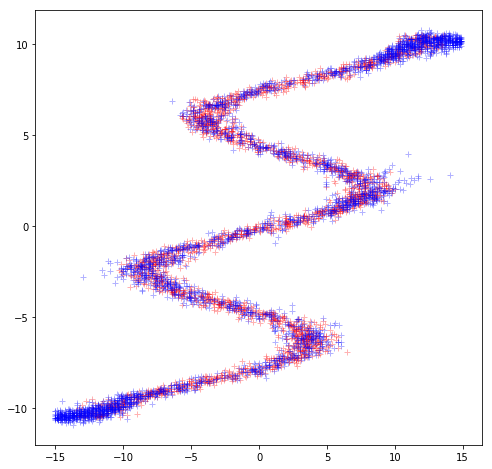

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'r+', x_test,y_test,'b+',alpha=0.3)
plt.show()